# Calculate NDVI with MultiRasterIO

This tutorial shows how to use the ``MultiRasterIO`` class to process multiple single raster files with a custom (user defined) function in chunks or windows.
This can be useful if the input or generated data does not fit in memory. 

Here we define a custom function that calculates two different NDVI versions from the Sentinel 2 bands B04, B08 and B8A.

In this tutorial we need the following imports:

In [33]:
import fnmatch
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio

from eobox.raster import extract
from eobox.raster import MultiRasterIO
from eobox import sampledata

Furthermore we need some data. 
Here derive the paths to the three S2 bands required in the custom function to be developed. 

In [4]:
dataset = sampledata.get_dataset("s2l1c")
layer_files = fnmatch.filter(dataset["raster_files"], "*B04*")  # 10 m bands
layer_files += fnmatch.filter(dataset["raster_files"], "*B08*")  # 10 m bands
layer_files += fnmatch.filter(dataset["raster_files"], "*B8A*")  # 10 m bands
layer_files

['/home/ben/anaconda/envs/eobox/lib/python3.6/site-packages/eobox/sampledata/data/s2l1c/S2A_MSIL1C_20170216T102101_N0204_R065_T33UUU_20170216T102204.SAFE/S2A_MSIL1C_20170216T102101_N0204_R065_T33UUU_20170216T102204.SAFE/GRANULE/L1C_T33UUU_A008642_20170216T102204/IMG_DATA/T33UUU_20170216T102101_B04.jp2',
 '/home/ben/anaconda/envs/eobox/lib/python3.6/site-packages/eobox/sampledata/data/s2l1c/S2A_MSIL1C_20170216T102101_N0204_R065_T33UUU_20170216T102204.SAFE/S2A_MSIL1C_20170216T102101_N0204_R065_T33UUU_20170216T102204.SAFE/GRANULE/L1C_T33UUU_A008642_20170216T102204/IMG_DATA/T33UUU_20170216T102101_B08.jp2',
 '/home/ben/anaconda/envs/eobox/lib/python3.6/site-packages/eobox/sampledata/data/s2l1c/S2A_MSIL1C_20170216T102101_N0204_R065_T33UUU_20170216T102204.SAFE/S2A_MSIL1C_20170216T102101_N0204_R065_T33UUU_20170216T102204.SAFE/GRANULE/L1C_T33UUU_A008642_20170216T102204/IMG_DATA/T33UUU_20170216T102101_B8A.jp2']

## Develop a Custom Function

Assume we want to process these files with our own function, e.g. ``calculate_ndvi``, but but we need to do this chunk-wise because the whole input and/or output data does not fit in memory.
With ``MultiRasterIO`` we can focus on the developement of our function because the class facilitates the chunk-wise processing. 

Before we start developing our costum function, let us get a chunk of the data. This is usually useful for developing the function.

In the following cell we 

* initialize the ``MultiRasterIO`` class, 
* derive windows (the ones that are stored internally and can be derived with **ADD block_windows() LINK**,
* and load the first (index 0) chunk of data with.

In [7]:
mr = MultiRasterIO(layer_files=layer_files, dst_res=10)
mr.block_windows()
arr = mr.get_arrays(0)
arr.shape

(128, 128, 3)

Based on that data we can develop our custom function.

To make the custom function work with ``MultiRasterIO`` it is important that it meets the following two requirements:

* The first input argument must be a 3-dimensional array with the dimensions being (X, Y, Bands), just as loaded in the last cell. Note that the X, Y dimensions might vary in size with the chunk or window being processed. Additionally, any keword arguments can be defined.
* The output must be a list of arrays where the number of elements in the list corresponds to the output layers and the arrays are 2-dimensional with the dimensions being (X, Y).

The following function calculates two NDVIs from the S2 data, one with the NIR band B08 and the other with B8A.

In [13]:
def calculate_ndvi(arr, idx_b04, idx_b08, idx_b8a):
    """A custom function for calculating an NDVI based on the two S2 NIR bands."""
    import numpy as np
    def normalized_difference_index(arr, idx_minuend, idx_subtrahend):
        di = (arr[:,:,idx_minuend] - arr[:,:,idx_subtrahend]) / (arr[:,:,idx_minuend] + arr[:,:,idx_subtrahend])
        di[di > 1.0] = 1.0001
        di[di < -1.0] = -1.0001
        di = (di*10000).astype(np.int16)
        return di
    ndvi_b08 = normalized_difference_index(arr, idx_b08, idx_b04)
    ndvi_b8a = normalized_difference_index(arr, idx_b8a, idx_b04)
    return [ndvi_b08, ndvi_b8a]

ndvis = calculate_ndvi(arr, idx_b04=0, idx_b08=1, idx_b8a=2)
print(len(ndvis))
print(ndvis[0].shape)
print(ndvis[1].shape)


2
(128, 128)
(128, 128)


As expected it returns a list of two 2D-array.

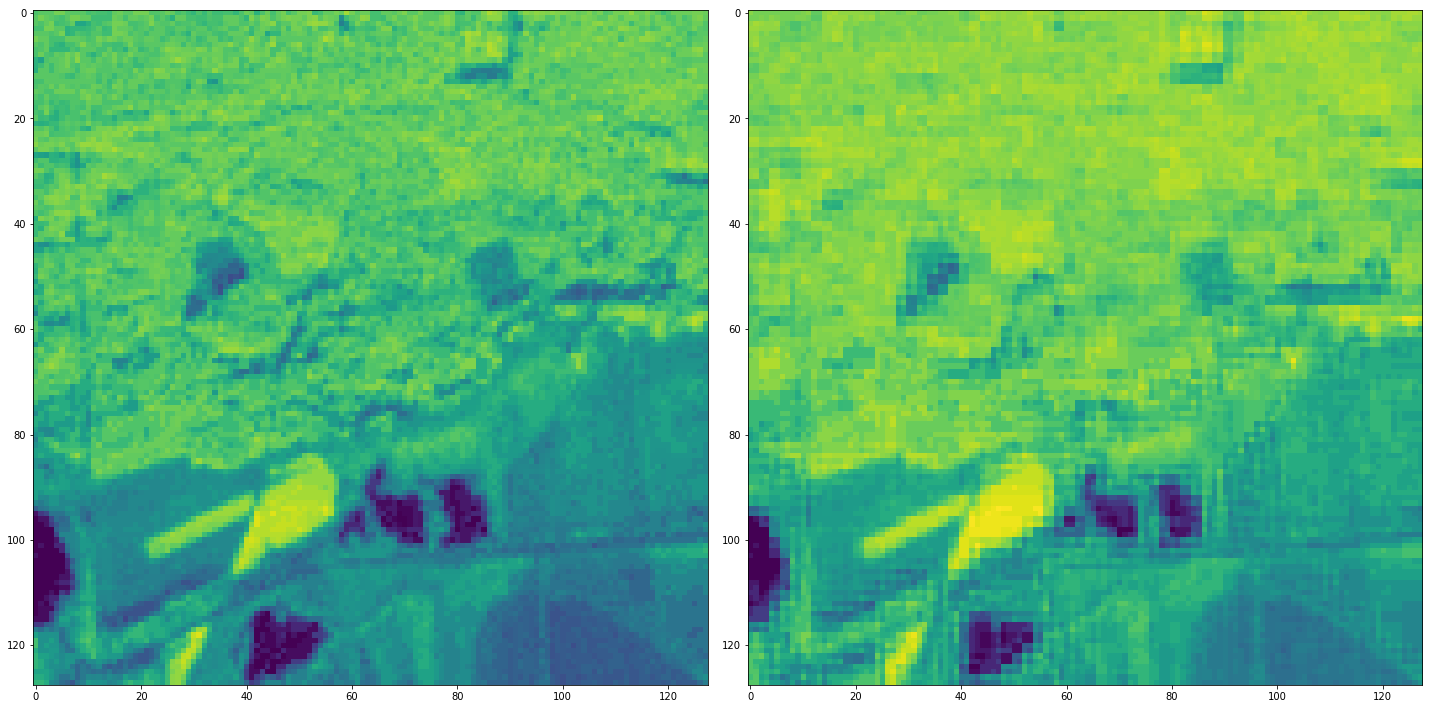

In [14]:
fig, axes = plt.subplots(1,2, figsize=(20, 10))

axes.flatten()[0].imshow(ndvis[0], vmin=-1000, vmax=6000)
axes.flatten()[1].imshow(ndvis[1], vmin=-1000, vmax=6000)
fig.tight_layout()

If we are happy with our function and if it meets the two above mentioned requirements we are ready to process the whole image.
To do so, all we need to do is to define a destination file per output layer.

In [30]:
dst_dir = Path(".").absolute() / "NDVI"
ndvi_files = [str(dst_dir / "ndvib08.jp2"),
              str(dst_dir / "ndvib8a.jp2")]

Then we can just pass the destination filenames, the custom function and it required its keword arguments to the ``apply_and_save`` method and wait for the result. 

In [31]:
exit_code = mr.apply_and_save(dst_files=ndvi_files,
                              func=calculate_ndvi,
                              idx_b04=0, idx_b08=1, idx_b8a=2)
assert exit_code == 0

Lets load and plot the array of the created NDVI layers:

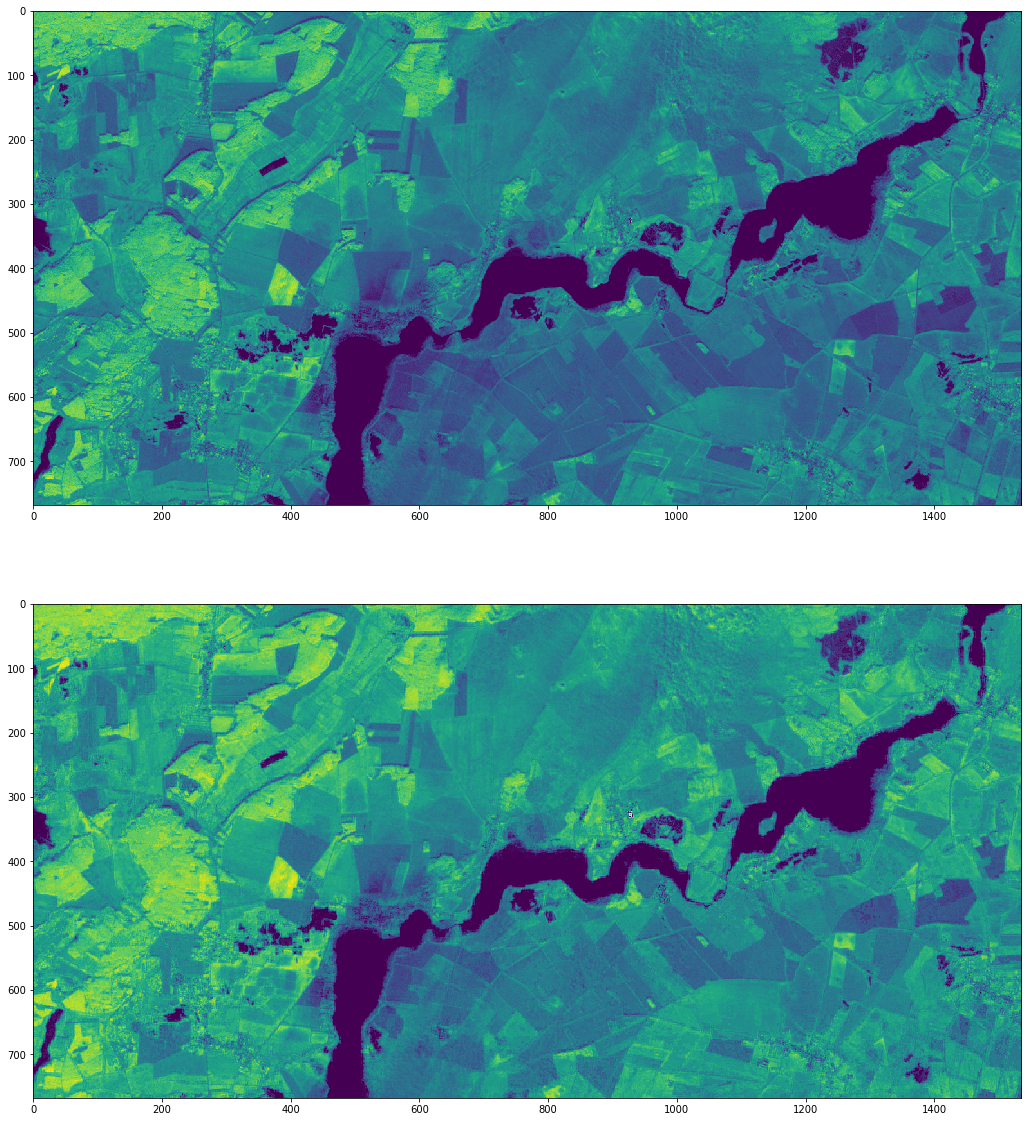

In [38]:
fig, axes = plt.subplots(2,1, figsize=(20, 20))
with rasterio.open(ndvi_files[0]) as ndvib08:
    arr = ndvib08.read()
    axes.flatten()[0].imshow(arr[0,:,:], vmin=-1000, vmax=6000)
with rasterio.open(ndvi_files[1]) as ndvib8a:
    arr = ndvib8a.read()
    axes.flatten()[1].imshow(arr[0,:,:], vmin=-1000, vmax=6000)